# Gesundheitsministerium and ECDC Data

## Setup

### Imports

In [2]:
%matplotlib notebook

import logging
logging.basicConfig(level=logging.ERROR)

import calendar

from datetime import timedelta, datetime

from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')


import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth',None)

from helper import *
from austria import Austria
from ecdc import ECDC

today =f'{datetime.now().year}_{datetime.now().month:02d}_{datetime.now().day:02d}'
ecdc = ECDC()
AT = Austria()
print("TODAY: ", datetime.now(), "\nLatest case date: ", AT.epicurve.time.max(),
      "\nTimestamps: ", AT.epicurve.Timestamp.unique())

TODAY:  2020-11-25 17:13:17.411821 
Latest case date:  2020-11-24 00:00:00 
Timestamps:  ['2020-11-25T17:02:00']


## Cases


### Weekly

<IPython.core.display.Javascript object>


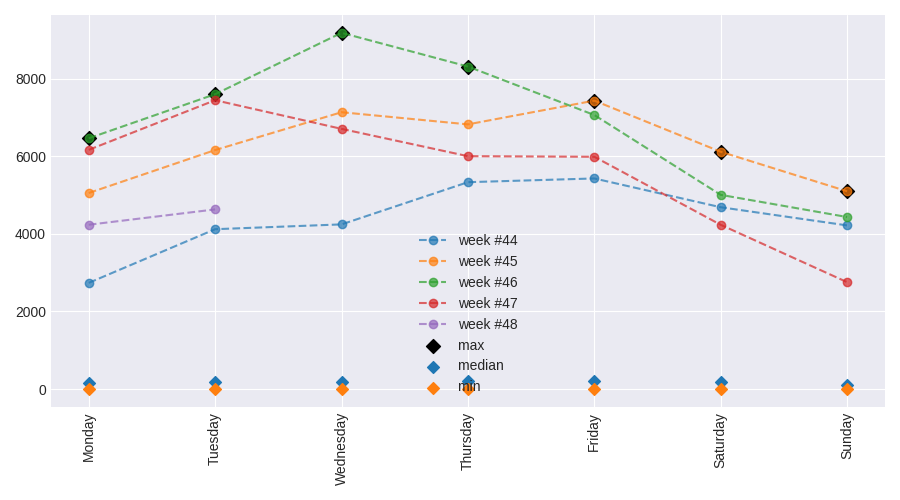

<IntegerArray>
[44, 45, 46, 47, 48]
Length: 5, dtype: UInt32


<AxesSubplot:>

In [3]:
AT.plot_cases_by_day_of_the_week()

### Time Series

<IPython.core.display.Javascript object>


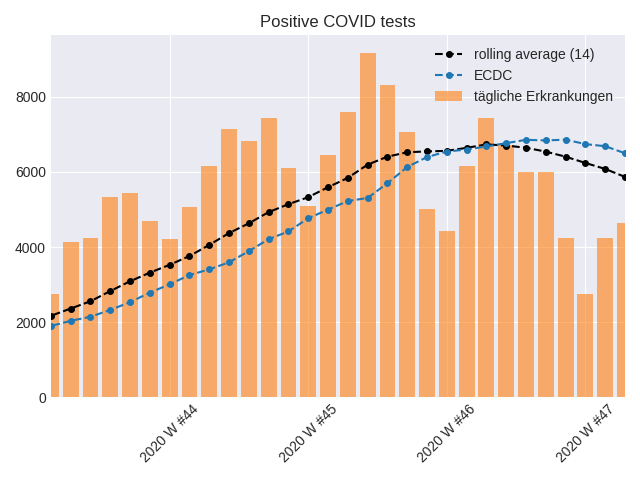

[Timestamp('2020-10-26 00:00:00'), Timestamp('2020-11-24 00:00:00')]


(259959, 253349)

In [4]:

# ax.bar(df_at.time, df_at['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')

ax = AT.plot_tägliche_erkrankungen(roll_days=14)

selection =  ecdc.select_country('AT').sort_values(by=['year','month','day'], ascending=True)
# ax.plot(,.rolling(14).mean(), marker='o', markersize=4, linestyle='--')
ax = plot_rolling_avg(ax, x=selection.dateRep, y= selection['cases'], roll_days=14, label='ECDC', color='C0')

# plt.yscale('log')


plt.xticks(rotation=45);
plt.legend(loc='best')
plt.tight_layout()

AT.epicurve['tägliche Erkrankungen'].sum(), ecdc.select_country('AT').cases.sum()



### Last 5 days

In [5]:
 ecdc.overview(ecdc.select_country('AT'))

dateRep        cases                                \
                            latest  rolling_avg                   last_5_days   
countriesAndTerritories                                                         
Austria                 2020-11-25  5698.142857  6612, 6239, 5215, 3090, 4135   

                               deaths                              \
                           max    sum last_7_days_sum rolling_avg   
countriesAndTerritories                                             
Austria                  10368   2408             593   84.714286   

                                                   \
                                 last_5_days  max   
countriesAndTerritories                             
Austria                  79, 58, 44, 94, 115  115   

                        Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                            latest   
countriesAndTerritories                                                              
Austria                                                                1030.593959   

                                      
                                 max  
countriesAndTerritories               
Austria                  1084.416299

In [6]:
AT.epicurve.sort_values('time').tail(5)

,time,tägliche Erkrankungen,Timestamp,weekday
269,2020-11-20,5988,2020-11-25T17:02:00,4
270,2020-11-21,4234,2020-11-25T17:02:00,5
271,2020-11-22,2756,2020-11-25T17:02:00,6
272,2020-11-23,4236,2020-11-25T17:02:00,0
273,2020-11-24,4631,2020-11-25T17:02:00,1


In [7]:
AT.epicurve.time.max()

Timestamp('2020-11-24 00:00:00')

In [8]:
AT.epicurve.agg(
        {'tägliche Erkrankungen': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'time': ['min', 'max']} )


,tägliche Erkrankungen,time
last_7_days_sum,34555.000000,NaT
latest,4631.000000,NaT
max,9183.000000,2020-11-24
min,NaN,2020-02-25
rolling_avg,4936.428571,NaT
sum,259959.000000,NaT


## Number of Cases

### Vienna

2020-11-24 00:00:00


<IPython.core.display.Javascript object>


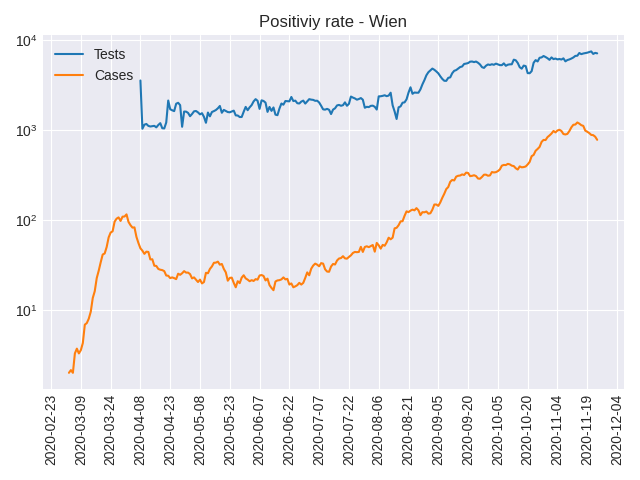

<AxesSubplot:title={'center':'Positiviy rate - Wien'}>

In [9]:
AT.plot_positivity_rate(bundesland='Wien')

### Cases and Deaths (from ECDC)

<IPython.core.display.Javascript object>


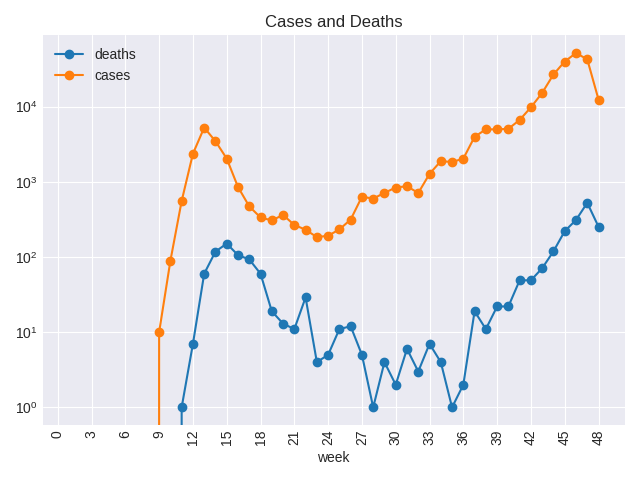

In [10]:
df_at = ecdc.df[ecdc.df.geoId=='AT']
f,ax=plt.subplots()
df_at.groupby(by=df_at.dateRep.dt.isocalendar().week).agg({'deaths':'sum', 'cases': 'sum'}).plot(ax=ax,marker='o')
pretty_plot(ax=ax,log=True,title='Cases and Deaths')

## Corona Ampel

In [11]:
ampel = AT.ampel_aktuell

# ampel.sort_values('Warnstufe', ascending=False).head(10)
ampel.groupby('Warnstufe').agg({'Name':concat, 'Region': 'count'})

,Name,Region
Warnstufe,,
4,"Eisenstadt(Stadt), Rust(Stadt), Eisenstadt-Umgebung, Güssing, Jennersdorf, Mattersburg, Neusiedl am See, Oberpullendorf, Oberwart, Klagenfurt Stadt, Villach Stadt, Hermagor, Klagenfurt Land, Sankt Veit an der Glan, Spittal an der Drau, Villach Land, Völkermarkt, Wolfsberg, Feldkirchen, Krems an der Donau(Stadt), Sankt Pölten(Stadt), Waidhofen an der Ybbs(Stadt), Wiener Neustadt(Stadt), Amstetten, Baden, Bruck an der Leitha, Gänserndorf, Gmünd, Hollabrunn, Horn, Korneuburg, Krems(Land), Lilienfeld, Melk, Mistelbach, Mödling, Neunkirchen, Sankt Pölten(Land), Scheibbs, Tulln, Waidhofen an der Thaya, Wiener Neustadt(Land), Zwettl, Linz(Stadt), Steyr(Stadt), Wels(Stadt), Braunau am Inn, Eferding, Freistadt, Gmunden, Grieskirchen, Kirchdorf an der Krems, Linz-Land, Perg, Ried im Innkreis, Rohrbach, Schärding, Steyr-Land, Urfahr-Umgebung, Vöcklabruck, Wels-Land, Salzburg(Stadt), Hallein, Salzburg-Umgebung, Sankt Johann im Pongau, Tamsweg, Zell am See, Graz(Stadt), Deutschlandsberg, Graz-Umgebung, Leibnitz, Leoben, Liezen, Murau, Voitsberg, Weiz, Murtal, Bruck-Mürzzuschlag, Hartberg-Fürstenfeld, Südoststeiermark, Innsbruck-Stadt, Imst, Innsbruck-Land, Kitzbühel, Kufstein, Landeck, Lienz, Reutte, Schwaz, Bludenz, Bregenz, Dornbirn, Feldkirch, Burgenland, Kärnten, Niederösterreich, Oberösterreich, Salzburg, Steiermark, Tirol, Vorarlberg, Wien, Bartholomäberg, Blons, Bludenz, Bludesch, Brand, Bürs, Bürserberg, Dalaas, Fontanella, Gaschurn, Innerbraz, Klösterle, Lech, Lorüns, Ludesch, Nenzing, Nüziders, Raggal, St. Anton im Montafon, St. Gallenkirch, St. Gerold, Schruns, Silbertal, Sonntag, Stallehr, Thüringen, Thüringerberg, Tschagguns, Vandans, Alberschwende, Andelsbuch, Au, Bezau, Bildstein, Bizau, Bregenz, Buch, Damüls, Doren, Egg, Eichenberg, Fußach, Gaißau, Hard, Hittisau, Höchst, Hörbranz, Hohenweiler, Kennelbach, Krumbach, Langen bei Bregenz, Langenegg, Lauterach, Lingenau, Lochau, Mellau, Mittelberg, Möggers, Reuthe, Riefensberg, Schnepfau, Schoppernau, Schröcken, Schwarzach, Schwarzenberg, Sibratsgfäll, Sulzberg, Warth, Wolfurt, Dornbirn, Hohenems, Lustenau, Altach, Düns, Dünserberg, Feldkirch, Frastanz, Fraxern, Göfis, Götzis, Klaus, Koblach, Laterns, Mäder, Meiningen, Rankweil, Röns, Röthis, Satteins, Schlins, Schnifis, Sulz, Übersaxen, Viktorsberg, Weiler, Zwischenwasser, nan",199


## Future Occupancy

In [12]:
def predict_future(past_days, past_y, ndays=14, predict_days=30, degree_fit=2):
    '''
    @ndays: number of days to consider from the end for predicting future
    '''
    past_y = np.array(past_y)
    future = np.arange(0,ndays+predict_days)
    past_days = past_days.dt.to_pydatetime()
    future_days = pd.date_range(start =past_days[-ndays], 
                                end =past_days[-1]+ timedelta(days=predict_days)).to_list()

    x = np.arange(ndays)    
    z = np.polyfit(x,past_y[-ndays:], degree_fit)    
    p = np.poly1d(z)    
    return future_days, p(future)


In [22]:
NDAYS=30
latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
print(f'As of {AT.fall_zählen.MeldeDatum.max()}')
data = []
for bundesland in AT.fall_zählen.Bundesland.unique():
    bundesland_data = {'bundesland': bundesland}
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]
    bundesland_data['ICUFree'] = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]
    bundesland_data['HospFree'] = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]
    predict_days =  300
    days_left_icu = []
    days_left_hosp = []
    for degree_fit in (1,2,3):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_icu.append( np.argmax(y>=limit_ICU)-NDAYS)
        else:
            days_left_icu.append(1000)

        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_hosp.append( np.argmax(y>=limit_Hosp)-NDAYS)
        else:
            days_left_hosp.append( 1000)


        
    bundesland_data['daysLeftICU'] = days_left_icu    
    bundesland_data['ICUMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_icu)))
    bundesland_data['ICUMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_icu)))
    bundesland_data['daysLeftHosp'] = days_left_hosp
    
    bundesland_data['HospMax_worst'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(min(days_left_hosp)))
    bundesland_data['HospMax_best'] = AT.fall_zählen.MeldeDatum.max() + timedelta(days=int(max(days_left_hosp)))

    data.append(bundesland_data)
    
df_future = pd.DataFrame(data)
df_future.sort_values(by='ICUFree')

As of 2020-11-24 00:00:00


,bundesland,ICUFree,HospFree,daysLeftICU,ICUMax_worst,ICUMax_best,daysLeftHosp,HospMax_worst,HospMax_best
3,Oberösterreich,9,283,"[0, 7, 1000]",2020-11-24,2023-08-21,"[5, 1000, 1000]",2020-11-29,2023-08-21
6,Tirol,13,80,"[1, 1000, 1000]",2020-11-25,2023-08-21,"[7, 9, 1000]",2020-12-01,2023-08-21
0,Burgenland,16,87,"[24, 1000, 1000]",2020-12-18,2023-08-21,"[25, 1000, 1000]",2020-12-19,2023-08-21
4,Salzburg,21,47,"[41, 1000, 60]",2021-01-04,2023-08-21,"[7, 6, 1000]",2020-11-30,2023-08-21
7,Vorarlberg,24,285,"[15, 1000, 1000]",2020-12-09,2023-08-21,"[59, 1000, 64]",2021-01-22,2023-08-21
1,Kärnten,25,64,"[19, 10, 1000]",2020-12-04,2023-08-21,"[5, 2, 1000]",2020-11-26,2023-08-21
5,Steiermark,34,367,"[8, 8, 1000]",2020-12-02,2023-08-21,"[15, 1000, 1000]",2020-12-09,2023-08-21
2,Niederösterreich,100,419,"[37, 23, 17]",2020-12-11,2020-12-31,"[19, 1000, 1000]",2020-12-13,2023-08-21
8,Wien,261,1930,"[73, 1000, 1000]",2021-02-05,2023-08-21,"[147, 1000, 1000]",2021-04-20,2023-08-21
9,Alle,503,3562,"[23, 1000, 1000]",2020-12-17,2023-08-21,"[28, 1000, 1000]",2020-12-22,2023-08-21


### Plots

<IPython.core.display.Javascript object>


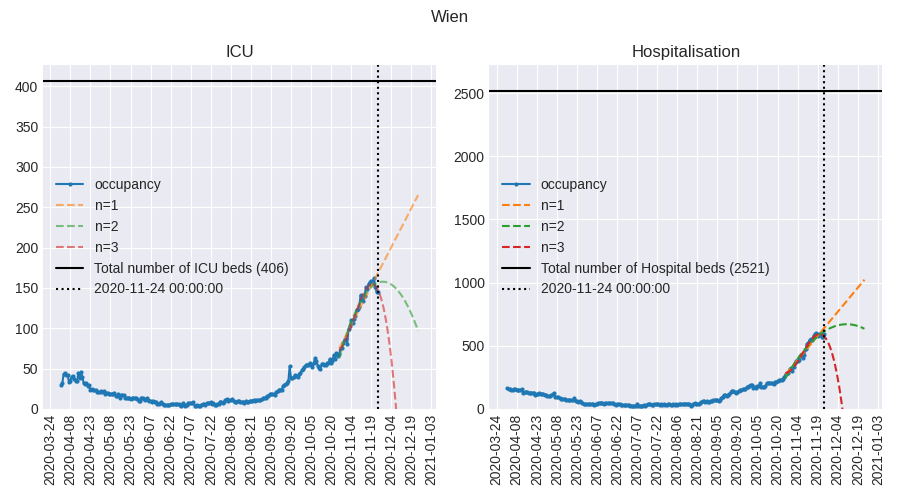

<IPython.core.display.Javascript object>


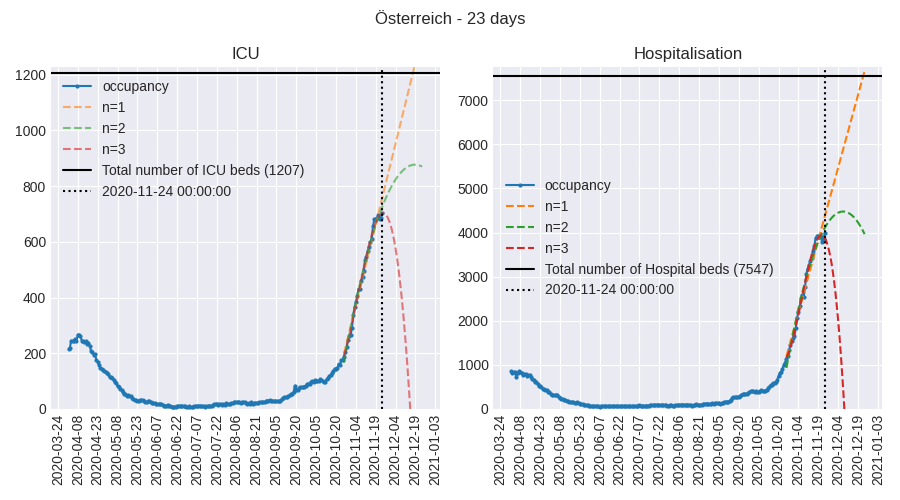

In [23]:


latest_df = AT.fall_zählen[AT.fall_zählen.MeldeDatum==AT.fall_zählen.MeldeDatum.max()].sort_values('FZHospFree')
for bundesland in [ 'Wien', 'Alle']:
    f, ax = plt.subplots(ncols=2,sharex=True, figsize=(9,5))
    df = AT.fall_zählen[AT.fall_zählen.Bundesland==bundesland]
    limit_ICU = latest_df[latest_df.Bundesland==bundesland].FZICUFree.iloc[0]  + \
                latest_df[latest_df.Bundesland==bundesland].FZICU.iloc[0]
    limit_Hosp = latest_df[latest_df.Bundesland==bundesland].FZHospFree.iloc[0]  + \
                 latest_df[latest_df.Bundesland==bundesland].FZHosp.iloc[0]

    predict_days =  max(int(latest_df.FZICUFree.iloc[0]),30)

    ax[0].plot(df.MeldeDatum, df.FZICU, label='occupancy', marker='o',markersize=2)
    ax[1].plot(df.MeldeDatum, df.FZHosp, label='occupancy', marker='o',markersize=2)

#     print(latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])
    days_left_ICU = []
    days_left_Hosp = []
    for degree_fit in (1,2,3):
        
        x,y = predict_future(df.MeldeDatum, df.FZICU, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        ax[0].plot(x, y, linestyle='--', label=f'n={degree_fit}', alpha=0.6)
        if y[np.argmax(y>=limit_ICU)] >= limit_ICU:
            days_left_ICU.append(np.argmax(y>=limit_ICU)-NDAYS)
       
        x,y = predict_future(df.MeldeDatum, df.FZHosp, ndays=NDAYS, predict_days=predict_days, degree_fit=degree_fit)
        ax[1].plot(x, y, linestyle='--', label=f'n={degree_fit}')
        if y[np.argmax(y>=limit_Hosp)] >= limit_Hosp:
            days_left_Hosp.append(np.argmax(y>=limit_Hosp)-NDAYS)
        
    ax[0].axhline(y=limit_ICU,color='k', label=f'Total number of ICU beds ({limit_ICU})')
    ax[1].axhline(y=limit_Hosp,color='k', label=f'Total number of Hospital beds ({limit_Hosp})')
    ax[0].set_ylim(0,limit_ICU+20)
    ax[1].set_ylim(0,limit_Hosp+200)
    ax[0].axvline(x=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0],
           color='k', linestyle='dotted',
           label=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])
    ax[1].axvline(x=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0],
           color='k', linestyle='dotted',
           label=latest_df[latest_df.Bundesland==bundesland].MeldeDatum.iloc[0])

    title = bundesland if bundesland != 'Alle' else 'Österreich'
    if days_left_ICU:
        title = f'{title} - {min(days_left_ICU)} days'
    
    f.suptitle(title)
    ax[0].set_ylim(0,)
    pretty_plot(ax[0], title='ICU')
    pretty_plot(ax[1],title='Hospitalisation')
        
#     plt.savefig(f'ICU_{today}_{bundesland}.png')



## Bed capacity

<IPython.core.display.Javascript object>


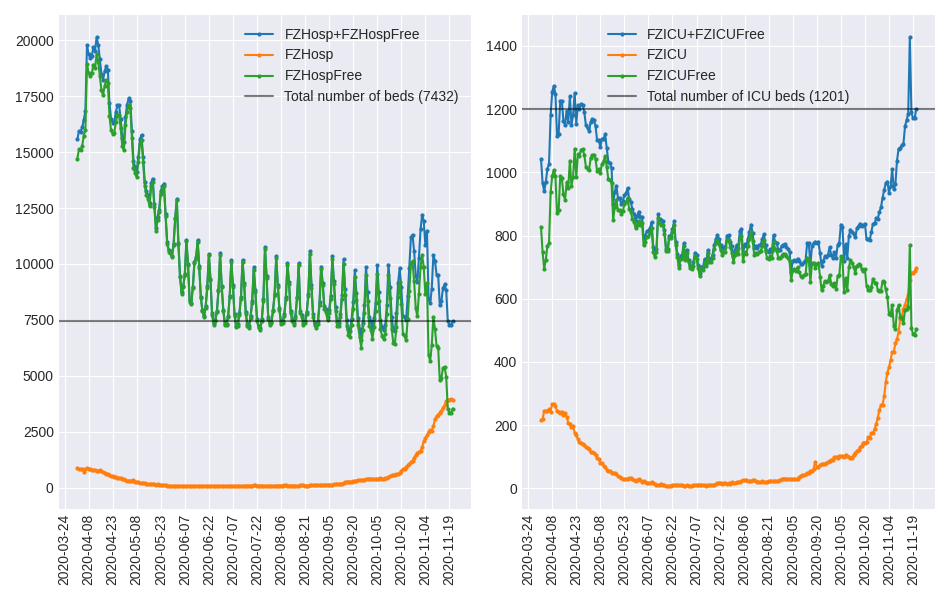

In [14]:
df = AT.fall_zählen[AT.fall_zählen.Bundesland=='Alle']

f,ax = plt.subplots(ncols=2, figsize=(9.5,6))
ax[0].plot(df.MeldeDatum, df.FZHosp+df.FZHospFree, label='FZHosp+FZHospFree',markersize=2, marker='o')    
ax[0].plot(df.MeldeDatum, df.FZHosp, label='FZHosp',markersize=2, marker='o')    
ax[0].plot(df.MeldeDatum, df.FZHospFree, label='FZHospFree',markersize=2, marker='o') 
ax[1].plot(df.MeldeDatum, df.FZICU+df.FZICUFree, label='FZICU+FZICUFree',markersize=2, marker='o')    
ax[1].plot(df.MeldeDatum, df.FZICU, label='FZICU',markersize=2, marker='o')    
ax[1].plot(df.MeldeDatum, df.FZICUFree, label='FZICUFree',markersize=2, marker='o')    
ax[0].axhline(y=df.FZHospFree.iloc[-1]+df.FZHosp.iloc[-1],color='k', label=f'Total number of beds ({limit_Hosp})',alpha=0.5)
ax[1].axhline(y=df.FZICUFree.iloc[-1]+df.FZICU.iloc[-1],color='k', label=f'Total number of ICU beds ({limit_ICU})',alpha=0.5)
# ax[0].set_ylabel('Number of Hospital Beds')
# ax[1].set_ylabel('Number of ICU Beds')
pretty_plot(ax[0])
pretty_plot(ax[1])

## Deaths

In [24]:
from gestorbene import Gestorbene
G = Gestorbene()
max(G.under_65.week_end)

Timestamp('2020-11-08 00:00:00')

### Overall Deaths

<IPython.core.display.Javascript object>


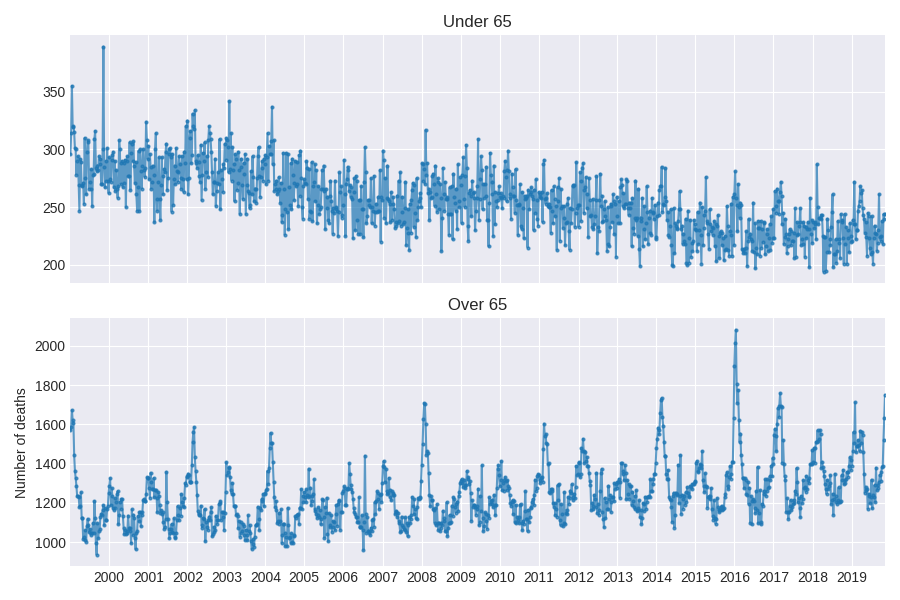

In [4]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end']).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y'))
plt.tight_layout()

### Group by month and year

<IPython.core.display.Javascript object>


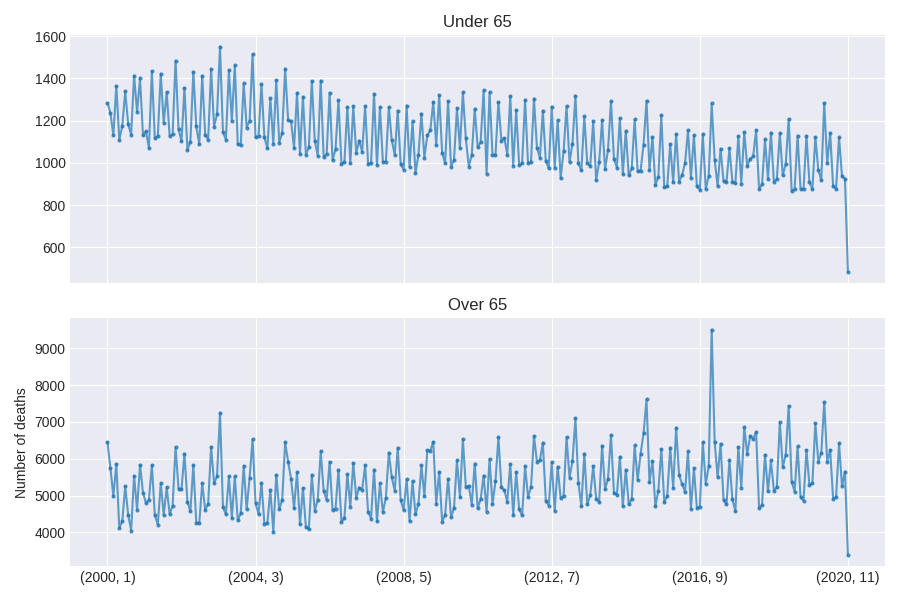

In [5]:
from matplotlib.ticker import FormatStrFormatter
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='M')

f, ax = plt.subplots(figsize=(9,6), sharex=True,nrows=2)
G.under_65.groupby(by=[G.under_65.week_end.dt.year, G.under_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(by=[G.over_65.week_end.dt.year, G.over_65.week_end.dt.month]).sum()['F-ANZ-1'].plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.ylabel('Number of deaths')
# ax[1].xaxis.set_major_locator(plt.MaxNLocator(50));

# plt.xticks(dates,zip( dates.strftime('%Y'),dates.strftime('%M')));
# ax[1].xaxis.set_major_formatter(FormatStrFormatter('%Y'));

plt.tight_layout()

### By Sex

<IPython.core.display.Javascript object>


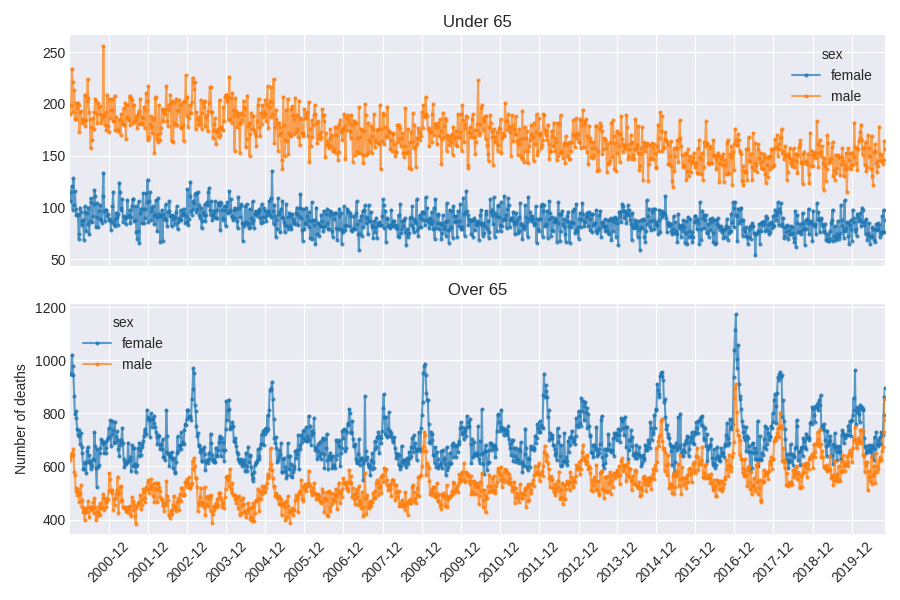

In [6]:
dates = pd.date_range(start=min(G.under_65.week_end), end = max(G.under_65.week_end),freq='Y',closed='left')
f, ax = plt.subplots(figsize=(9,6), sharex=True, nrows=2)
G.under_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[0], alpha=0.7, marker='o', markersize=2, title='Under 65')
G.over_65.groupby(['week_end','sex']).sum()['F-ANZ-1'].unstack().plot(ax=ax[1], alpha=0.7, marker='o', markersize=2, title='Over 65')
plt.xlabel('')
plt.xticks(rotation=45)

plt.ylabel('Number of deaths')
plt.xticks(dates, dates.strftime('%Y-%m'));
plt.tight_layout()

### Monthly

In [28]:
def aggregation_rules(fields, datefield):
    agg_rules = {}
    agg_rules[datefield] = latest
    for f in fields:
        agg_rules[f] = ('max', 'min', 'sum', 'median', latest)

    return agg_rules

def group_by_month(df, datefield, fields, include_last=False):
    agg_rules = aggregation_rules(fields, datefield)
    grouped = df.groupby(df[datefield].dt.month,
                         as_index=False).agg(agg_rules).sort_values(
                             (datefield, 'latest'))
    if not include_last:
        return grouped.iloc[:-1]

    # Cumsum
    ## new agg rules
    agg_rules = {(datefield, 'latest'): latest}
    for f in fields:
        agg_rules[(f, 'sum')] = 'cumsum'
        
    return grouped.groupby(df[(datefield, 'latest')].dt.month,
                           as_index=False).agg(agg_rules)

group_by_month(G.under_65,'week_end', ['F-ANZ-1'], include_last=True)


KeyError: ('week_end', 'latest')

Until 2020-11-08 00:00:00


<IPython.core.display.Javascript object>


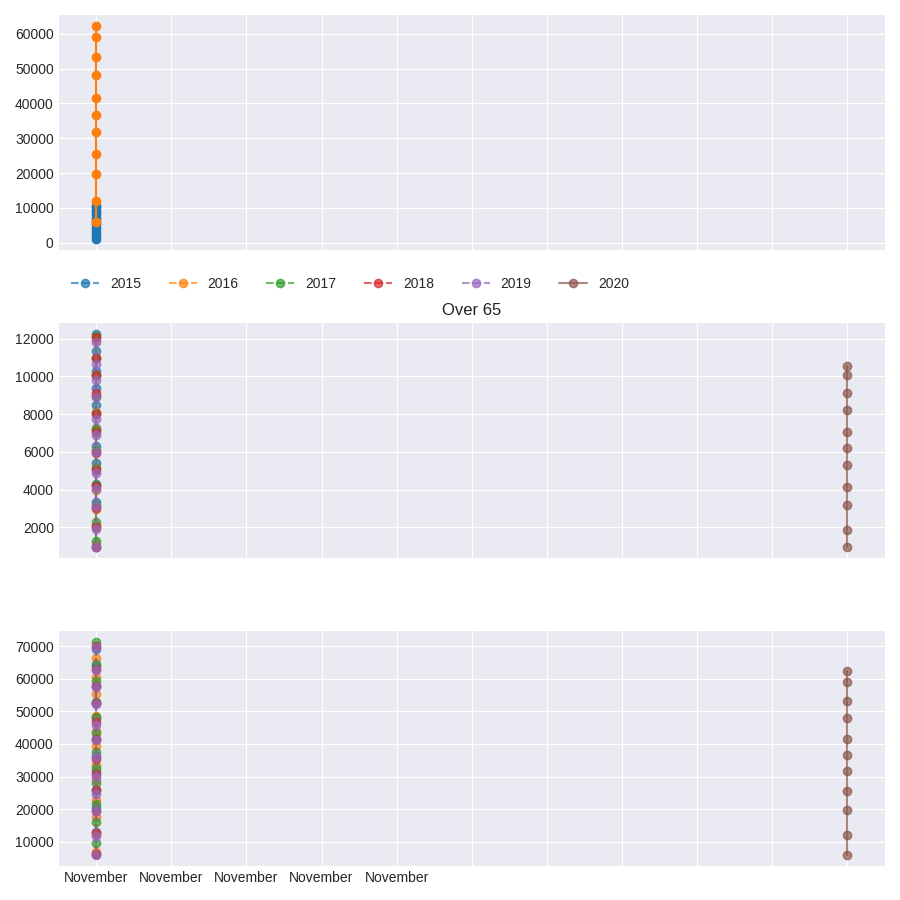

[2015, 2016, 2017, 2018, 2019, 2020]
MultiIndex([('week_end', 'latest'),
            ( 'F-ANZ-1',    'sum')],
           )
MultiIndex([('week_end', 'latest'),
            ( 'F-ANZ-1',    'sum')],
           )
MultiIndex([('week_end', 'latest'),
            ( 'F-ANZ-1',    'sum')],
           )
MultiIndex([('week_end', 'latest'),
            ( 'F-ANZ-1',    'sum')],
           )
MultiIndex([('week_end', 'latest'),
            ( 'F-ANZ-1',    'sum')],
           )
MultiIndex([('week_end', 'latest'),
            ( 'F-ANZ-1',    'sum')],
           )


In [26]:
current_year = datetime.now().year
print('Until', G.under_65.week_end.max())
f, ax = plt.subplots(figsize=(9,9),nrows=3, sharex=True)

last_5_years = sorted(G.under_65.week_end.dt.year.unique())[-6:]
print(last_5_years)

for y in last_5_years:
    linestyle = '-' if y == current_year else '--'
        
    df = G.under_65[G.under_65.week_end.dt.year == y]
    grouped = group_by_month(df, 'week_end', ['F-ANZ-1'], include_last=True)
    print(grouped.columns)
    ax[1].plot(grouped[('week_end','latest')].dt.month_name(), 
               grouped[('F-ANZ-1', 'sum')], 
               label=y, marker='o', 
               linestyle=linestyle,alpha=0.7)
    if y == current_year:
        ax[0].plot(grouped[('week_end','latest')].dt.month_name(), grouped[('F-ANZ-1', 'sum')], label='Under 65',marker='o')
    df = G.over_65[G.over_65.week_end.dt.year == y]
    grouped = group_by_month(df, 'week_end', ['F-ANZ-1'], include_last=True)
    ax[2].plot(grouped[('week_end','latest')].dt.month_name(), 
               grouped[('F-ANZ-1', 'sum')], 
               label=y,marker='o',linestyle=linestyle,alpha=0.7)
    if y == current_year:
        ax[0].plot(grouped[('week_end','latest')].dt.month_name(), grouped[('F-ANZ-1', 'sum')], label='Over 65',marker='o')

pretty_plot(ax[1],num_x_locators=13, show_legend=False, title='Over 65');


ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1.25),
          fancybox=True, shadow=True, ncol=10)
# df_at = ecdc.df[ecdc.df.geoId=='AT']
# df_at.groupby(by=df_at.dateRep.dt.month).agg({'deaths':'sum'}).plot(ax=ax[2],marker='o')

# pretty_plot(ax[2],log=False,title='Deaths from ECDC');
plt.tight_layout()


### Yearly

<IPython.core.display.Javascript object>


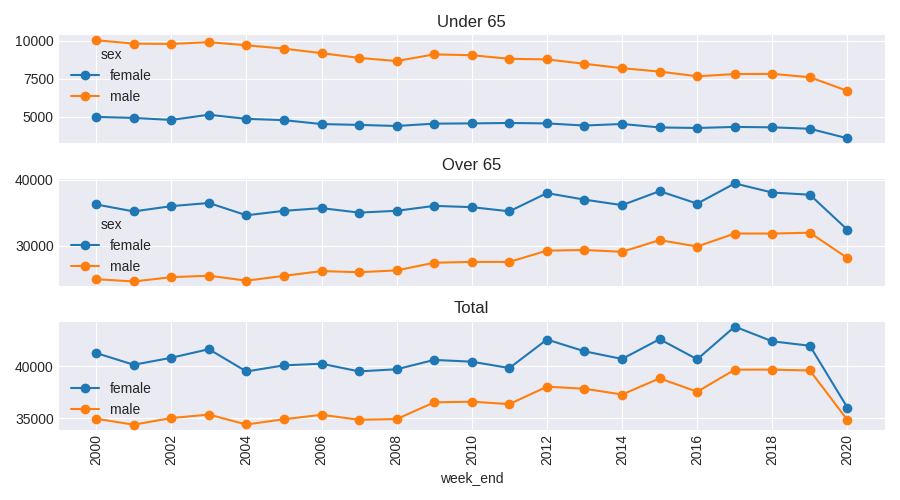

In [73]:
current_year = datetime.now().year
dfs = {'Under 65': G.under_65,
      'Over 65':  G.over_65,
      'Total': pd.concat([G.under_65, G.over_65])}

f, ax = plt.subplots(figsize=(9,5),nrows=len(dfs), sharex=True, sharey=False)
i = 0
for title, df in dfs.items():
    grouped = df.groupby(by=[df.week_end.dt.year,'sex']).agg('sum')
    grouped.head()
    grouped['F-ANZ-1'].unstack().plot(ax=ax[i], marker='o', title=title)
    i += 1
# 
pretty_plot(ax[-1],xticks=[df.week_end.dt.year.unique(),])
# ax[0].plot(grouped.index, grouped['F-ANZ-1'], marker='o', label='Under 65')

# pretty_plot(ax[0],xticks=(sorted(G.under_65.week_end.dt.year.unique()),))
# last_5_years = sorted(G.under_65.week_end.dt.year.unique())[-6:-1]
# print(last_5_years)
# for y in last_5_years:
#     df = G.under_65[G.under_65.week_end.dt.year == y]
#     grouped = group_by_month(df, 'week_end', ['G.under_65.week_end.dt.year'], include_last=True)
# #     print(grouped.head())
# #     break
#     ax[0].plot(grouped[('week_end','latest')].dt.year, 
#                grouped[('F-ANZ-1', 'sum')], 
#                label=y,
#                marker='o',
#                linestyle='--',
#                alpha=0.7)



In [74]:
pretty_plot(ax[1],num_x_locators=13, show_legend=False)
